<a href="https://colab.research.google.com/github/yamini-elite/NM/blob/main/quantium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Step 2: Load Data
txn_df = pd.read_excel('/content/QVI_transaction_data.xlsx')
cust_df = pd.read_csv('/content/QVI_purchase_behaviour.csv')

# Step 3: Clean Data
txn_df.dropna(inplace=True)
txn_df.drop_duplicates(inplace=True)
txn_df['DATE'] = pd.to_datetime(txn_df['DATE'])

# Step 4: Remove Salsa Products
txn_df = txn_df[~txn_df['PROD_NAME'].str.lower().str.contains("salsa")]

# Step 5: Remove Outlier (200 chip packs by 1 customer)
outlier_customer = txn_df[txn_df['PROD_QTY'] == 200]['LYLTY_CARD_NBR'].values[0]
txn_df = txn_df[txn_df['LYLTY_CARD_NBR'] != outlier_customer]


In [2]:
# Extract Brand (first word in product name)
txn_df['BRAND'] = txn_df['PROD_NAME'].apply(lambda x: x.split(' ')[0])

# Extract Pack Size from product name using regex
txn_df['PACK_SIZE'] = txn_df['PROD_NAME'].str.extract(r'(\d+)').astype(float)

# Check if results look okay
print(txn_df[['PROD_NAME', 'BRAND', 'PACK_SIZE']].head())


                                  PROD_NAME    BRAND  PACK_SIZE
0    Natural Chip        Compny SeaSalt175g  Natural      175.0
1                  CCs Nacho Cheese    175g      CCs      175.0
2    Smiths Crinkle Cut  Chips Chicken 170g   Smiths      170.0
3    Smiths Chip Thinly  S/Cream&Onion 175g   Smiths      175.0
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g   Kettle      150.0


In [3]:
# Merge both datasets on LYLTY_CARD_NBR
df = pd.merge(txn_df, cust_df, on='LYLTY_CARD_NBR', how='left')

# Quick check
df.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,BRAND,PACK_SIZE,LIFESTAGE,PREMIUM_CUSTOMER
0,1970-01-01 00:00:00.000043390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,Natural,175.0,YOUNG SINGLES/COUPLES,Premium
1,1970-01-01 00:00:00.000043599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,CCs,175.0,MIDAGE SINGLES/COUPLES,Budget
2,1970-01-01 00:00:00.000043605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,Smiths,170.0,MIDAGE SINGLES/COUPLES,Budget
3,1970-01-01 00:00:00.000043329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,Smiths,175.0,MIDAGE SINGLES/COUPLES,Budget
4,1970-01-01 00:00:00.000043330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,Kettle,150.0,MIDAGE SINGLES/COUPLES,Budget


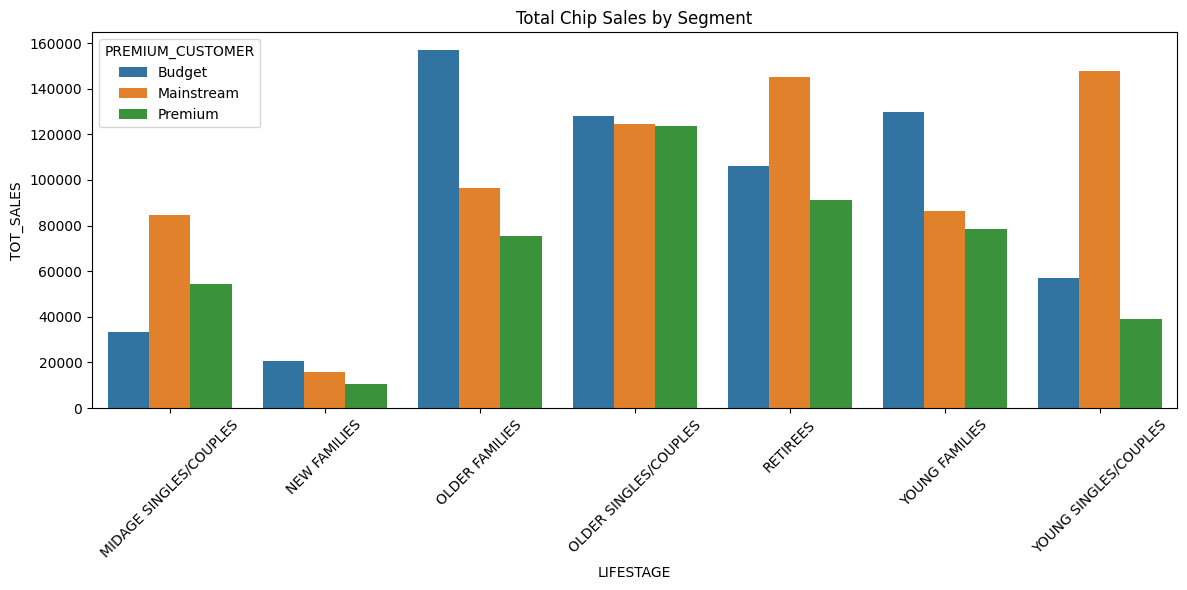

In [4]:
# Total sales by segment
sales_by_segment = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Visualize it
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_segment, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER')
plt.title('Total Chip Sales by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Insight: Who contributes most to chip sales?




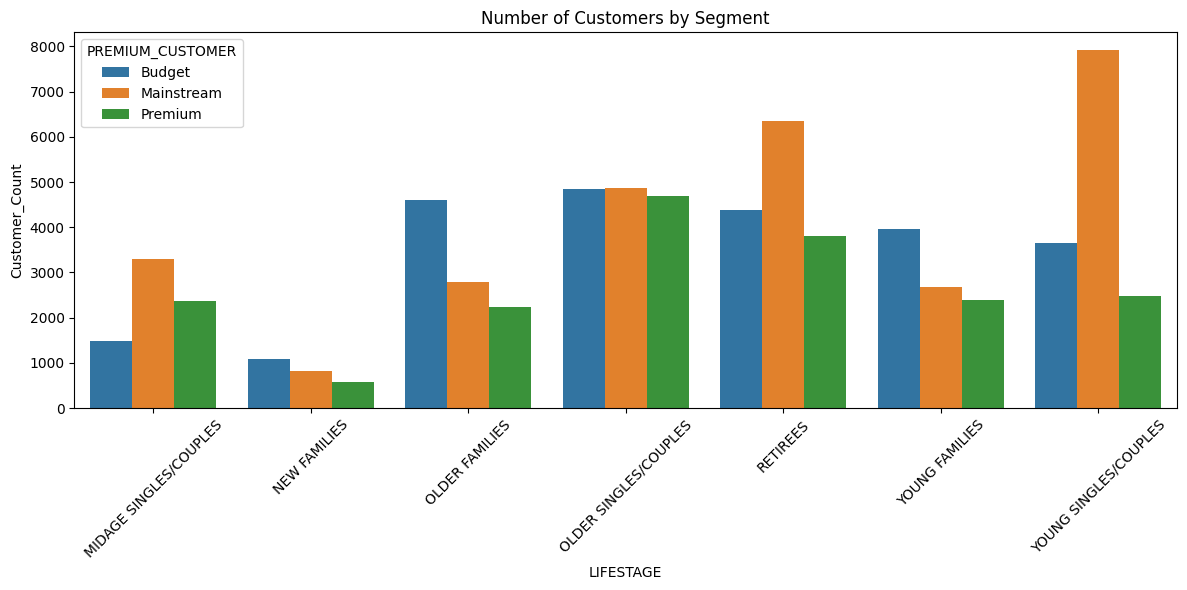

In [5]:
# Count unique customers per segment
cust_count = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index(name='Customer_Count')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=cust_count, x='LIFESTAGE', y='Customer_Count', hue='PREMIUM_CUSTOMER')
plt.title('Number of Customers by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#More customers = more sales? Or fewer but high-spending?

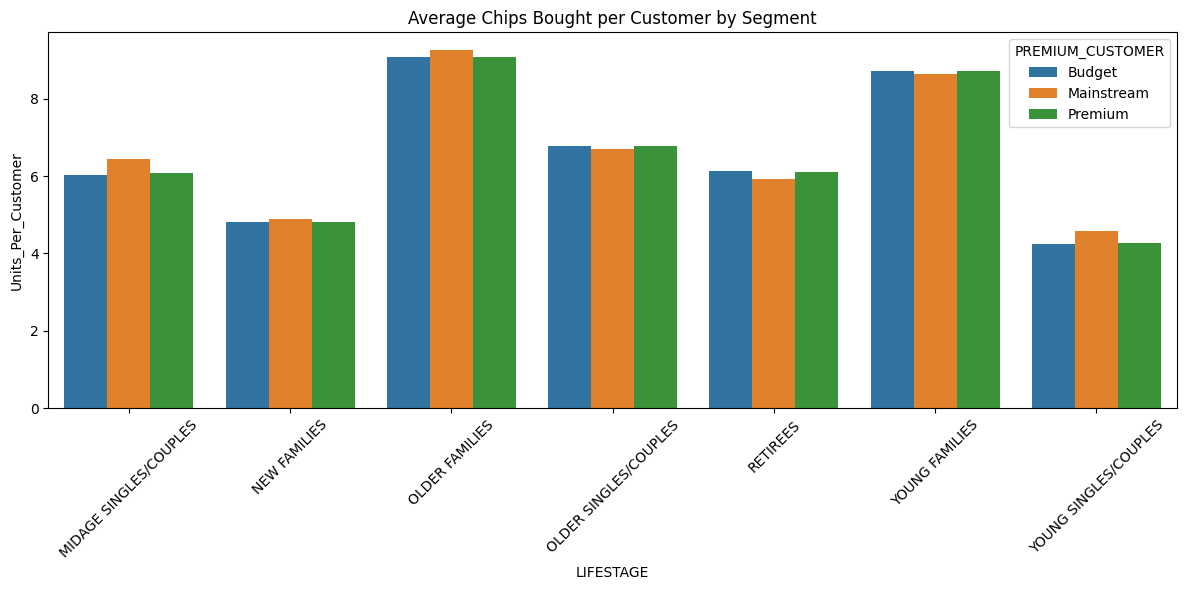

In [6]:
# Total units and number of customers
unit_data = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({
    'PROD_QTY': 'sum',
    'LYLTY_CARD_NBR': pd.Series.nunique
}).reset_index()

unit_data['Units_Per_Customer'] = unit_data['PROD_QTY'] / unit_data['LYLTY_CARD_NBR']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=unit_data, x='LIFESTAGE', y='Units_Per_Customer', hue='PREMIUM_CUSTOMER')
plt.title('Average Chips Bought per Customer by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Insight: Who buys the most quantity?



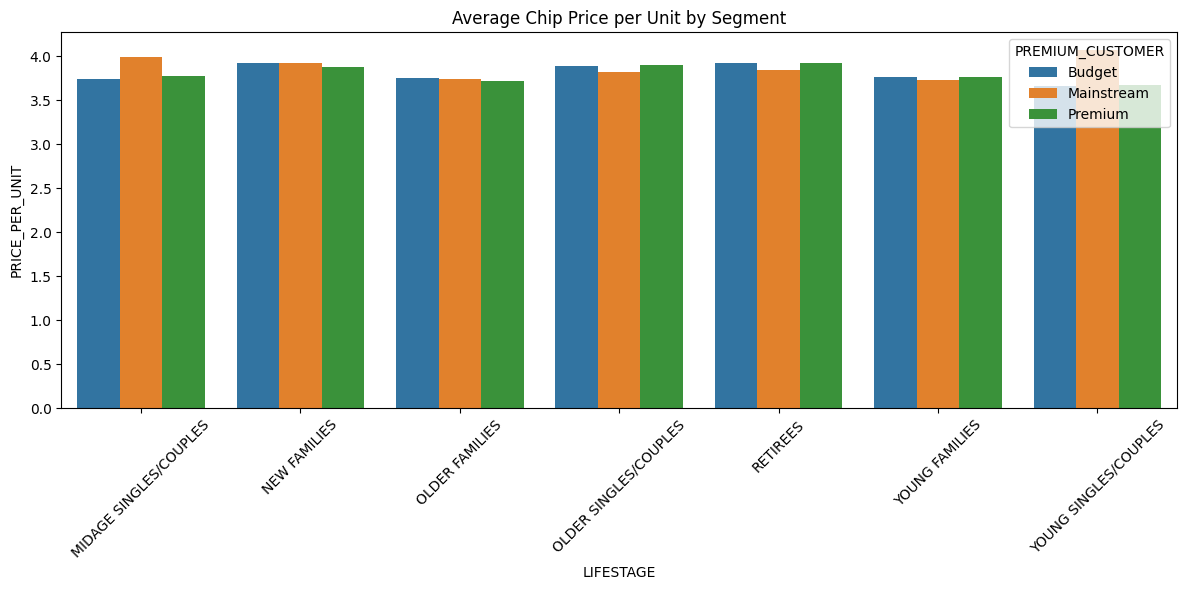

In [7]:
# Total sales / total quantity
df['PRICE_PER_UNIT'] = df['TOT_SALES'] / df['PROD_QTY']

price_per_unit = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=price_per_unit, x='LIFESTAGE', y='PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER')
plt.title('Average Chip Price per Unit by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Insight: Who is willing to pay more?

